<a href="https://www.kaggle.com/code/joewraga/forest-fires-and-random-forests?scriptVersionId=127335500" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
 
import numpy as np 
import pandas as pd 
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import sklearn.tree as tree
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forest-fires-data-set/forestfires.csv


In [2]:
df = pd.read_csv('/kaggle/input/forest-fires-data-set/forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


The target variable is the area burned in forest fires (in hectares), in northeastern Portugal, which is particularly affected by forest fires. A paper by Paulo Cortez
and An´ıbal Morais describing and tackling the problem is here: https://core.ac.uk/download/pdf/55609027.pdf (P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9). 

Documentation also available at UCI: https://archive.ics.uci.edu/ml/datasets/forest+fires. Some notes from the paper:

* Some of the features are related to fuel codes: FFMC refers to
moisture content surface litter and influences ignition and fire spread (ranges from 18.7 to 96.20). DMC (1.1 to 291.3)
and DC (7.9 to 860.6) are the moisture content of shallow and deep organic layers. ISI (0.0 to 56.10) is a score that correlates with fire velocity spread. RH is relative humidity in percentage (15.0 to 100). Temperature is in Celsius (2.2 to 33.30), wind speed is in km/h (0.40 to 9.40), and rain is in mm/m2 (0.0 to 6.4).

* Data were collected from January 2000 to December 2003.

* The values denote instant records, as given by station sensors when
the forest fire in question was detected (except for the rain variable, which denotes the accumulated
precipitation within the previous 30 minutes).

* They find that spatial coordinates (X, Y) and time features are not as important.

* Best RMSE: 63.7, Best MAD: 12.7. These are the metrics I'll be using to evaluate ML models.

* An area of zero actually means an area less than $100 m^2$ was burned (note, a hectare is $10^4 m^2$).

* Of the weather conditions, the outside temperature is
the most important feature, followed by the accumulated precipitation.


The spatial location of the fires is described with a $9 \times 9$ grid corresponding to the (X,Y) coordinates.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [6]:
display(df.dtypes)

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

To summarize,
* 2 categorical and 9 numerical features (and one numerical target variable)
* Target (area) very skewed toward zero
* No missing values

Let's look at the spread of the target variable, area:

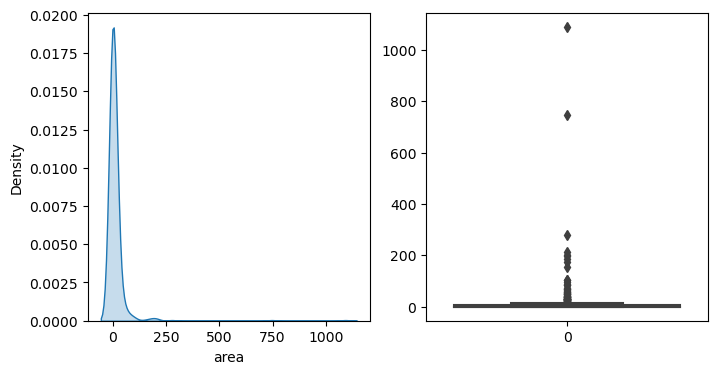

In [7]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(df['area'],fill=True,ax=ax[0])
sns.boxplot(df['area'],ax=ax[1])
fig.show()

The target is heavily skewed toward small values, with all larger ones being essentially outliers. As described in the documentation and paper, because the data are right-skewed, it is probably better to work with the transformation $x \rightarrow ln(1+x)$:

Skewness: 12.846933533934868
Skewness after log transform: 1.2178376559535011


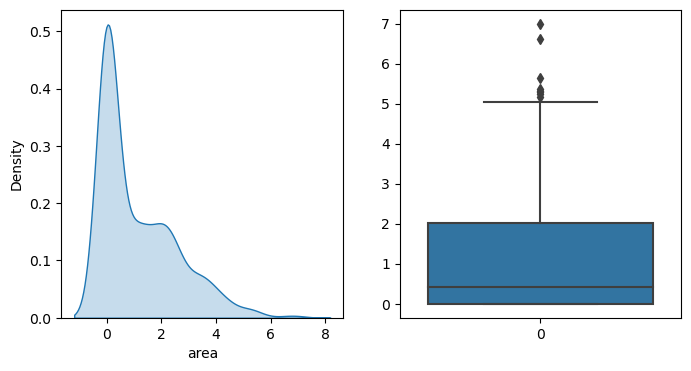

In [8]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
sns.kdeplot(np.log(1+df['area']),fill=True,ax=ax[0])
sns.boxplot(np.log(1+df['area']),ax=ax[1])
fig.show()
area_log = np.log(1 + df['area'])
print('Skewness:',df['area'].skew())
print('Skewness after log transform:',area_log.skew())

Let's look at some of the worst cases:

In [9]:
df.sort_values(['area'], ascending=[False]).head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
235,8,6,aug,sun,91.4,142.4,601.4,10.6,19.6,41,5.8,0.0,196.48
420,8,8,aug,wed,91.7,191.4,635.9,7.8,26.2,36,4.5,0.0,185.76
377,2,2,aug,sat,93.7,231.1,715.1,8.4,21.9,42,2.2,0.0,174.63
234,4,5,sep,sat,92.5,121.1,674.4,8.6,17.7,25,3.1,0.0,154.88
233,9,4,sep,tue,84.4,73.4,671.9,3.2,24.3,36,3.1,0.0,105.66


There are very few with a burned area greater than 100 ha.

In [10]:
df[df['area'] == 0.]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.0
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.0


In [11]:
df[df['area'] == 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.0
mean,4.518219,4.226721,90.219028,106.679757,522.878138,8.851822,18.427935,44.894737,3.913360,0.013765,0.0
std,2.230305,1.289898,6.965969,66.300811,264.637833,4.974102,5.344018,17.581779,1.681857,0.100268,0.0
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,4.200000,15.000000,0.900000,0.000000,0.0
25%,3.000000,4.000000,90.200000,51.300000,360.100000,6.300000,15.200000,32.000000,2.700000,0.000000,0.0
50%,4.000000,4.000000,91.600000,103.200000,661.300000,8.400000,18.600000,42.000000,3.600000,0.000000,0.0
75%,6.000000,5.000000,92.600000,142.400000,706.500000,10.600000,21.600000,54.000000,5.150000,0.000000,0.0
max,9.000000,9.000000,96.200000,290.000000,855.300000,56.100000,32.400000,100.000000,8.500000,1.000000,0.0


In [12]:
df[df['area'] != 0.].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,4.807407,4.366667,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,24.600185
std,2.383326,1.170740,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,86.501635
min,1.000000,2.000000,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.090000
25%,3.000000,4.000000,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,2.140000
50%,5.000000,4.000000,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,6.370000
75%,7.000000,5.000000,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,15.422500
max,9.000000,9.000000,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,1090.840000


Mean values: DC higher for nonzero damage, otherwise not much differences

Min values: Much higher FFMC for nonzero damage. Also DC is a bit higher. But the min temperature is, unintuitively, higher for the zero damage cases.

Max values: Max ISI is higher for zero damage case. Maximum rain also, oddly, higher for the case of large damage.

# Features

Let's look at how the features are distributed:

In [13]:
dfa = df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()
print('Categorical features:',cat_columns)
print('Numerical features:',num_columns)

Categorical features: ['month', 'day']
Numerical features: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


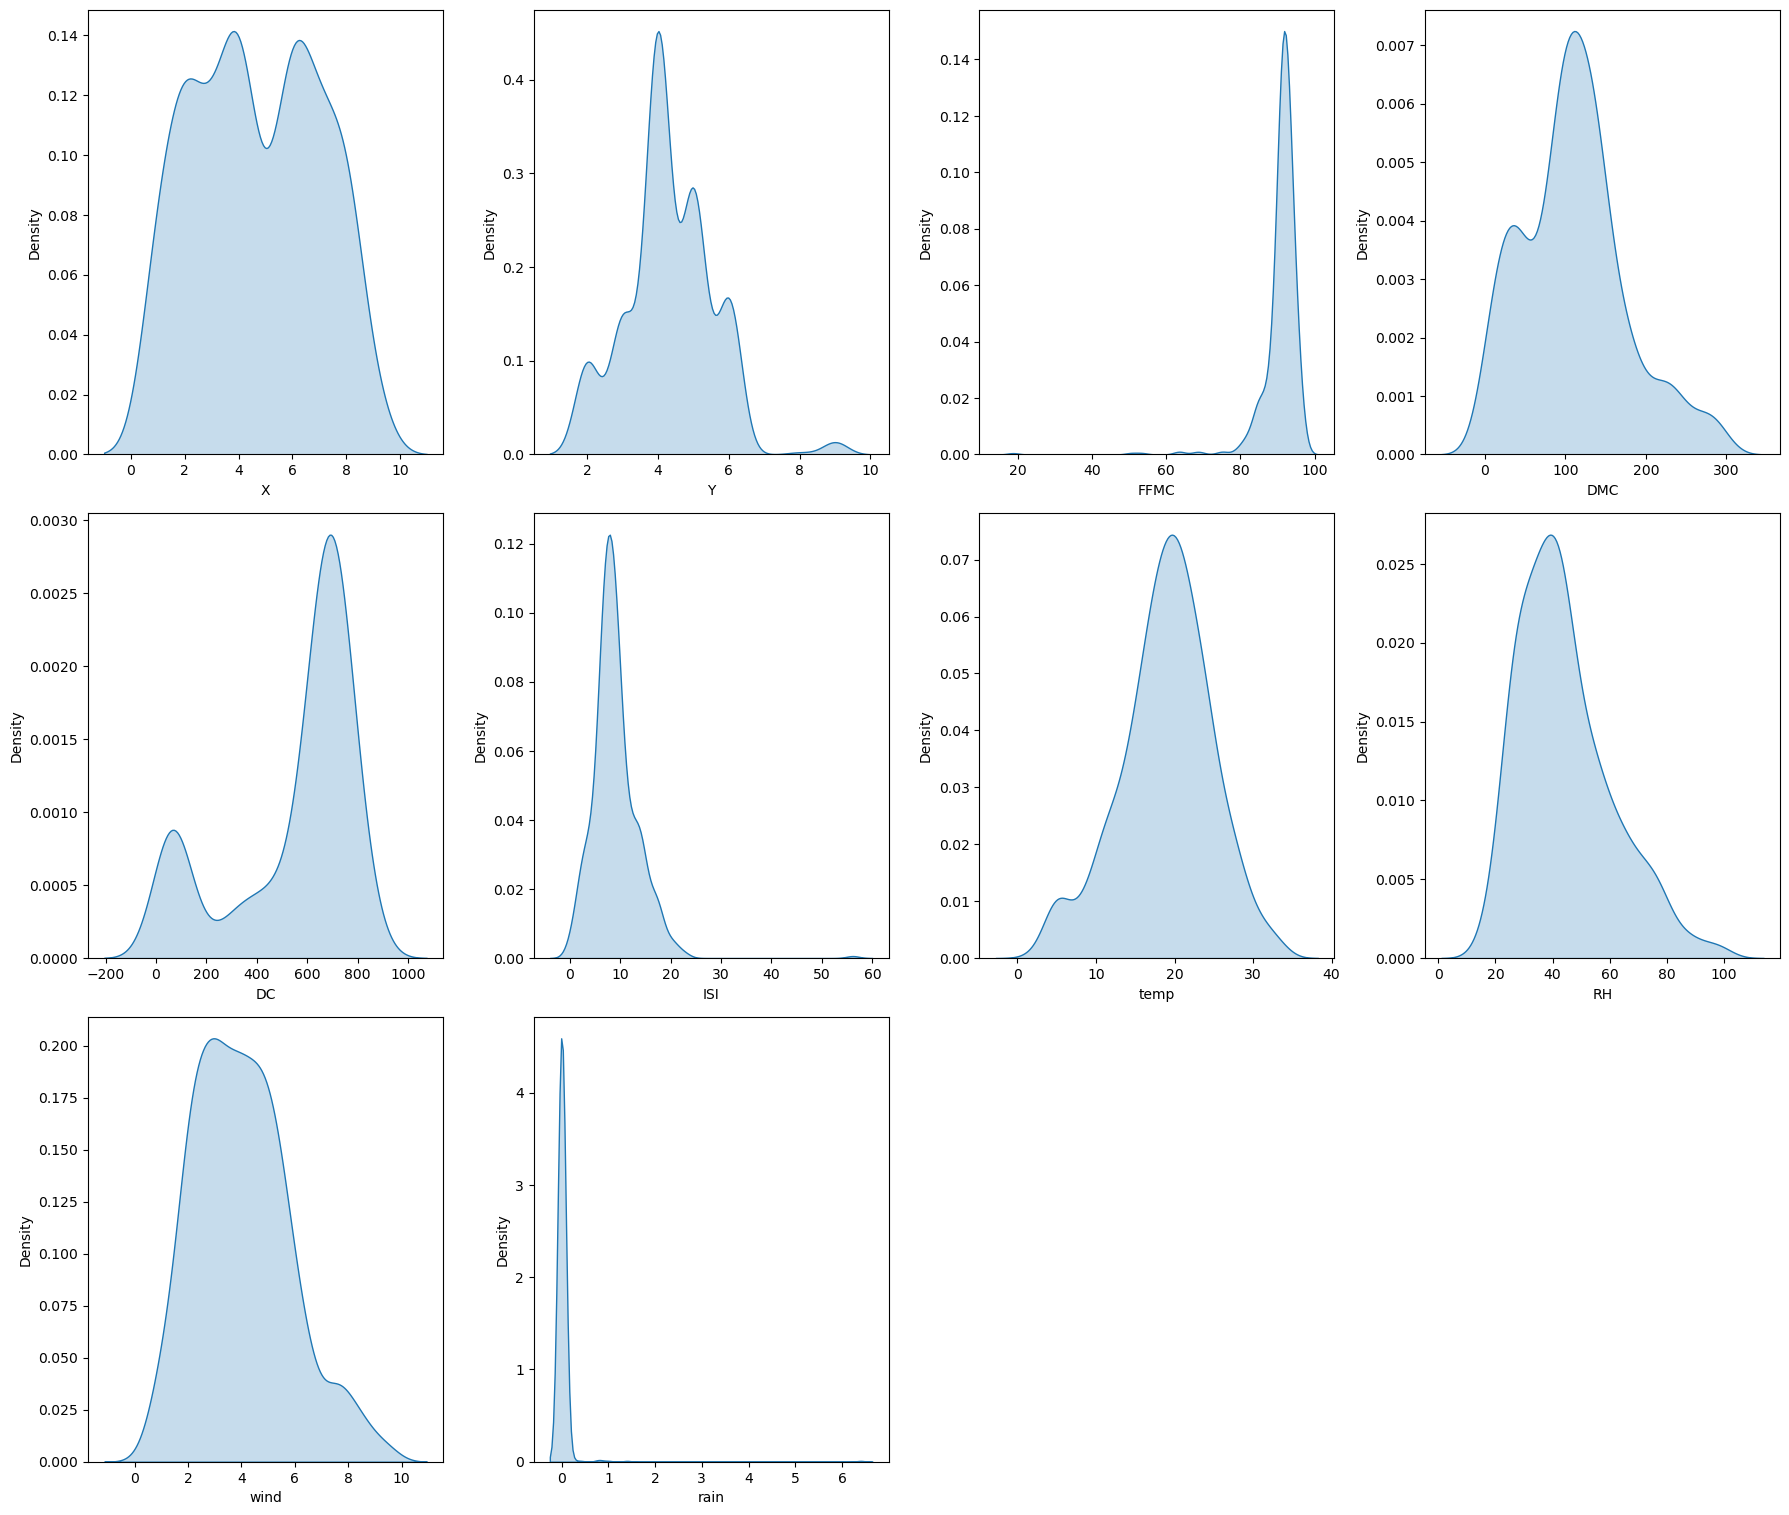

In [14]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],fill=True)
plt.tight_layout() 
plt.show()

A few (teperature, RH, wind) actually look close to Gaussian. 

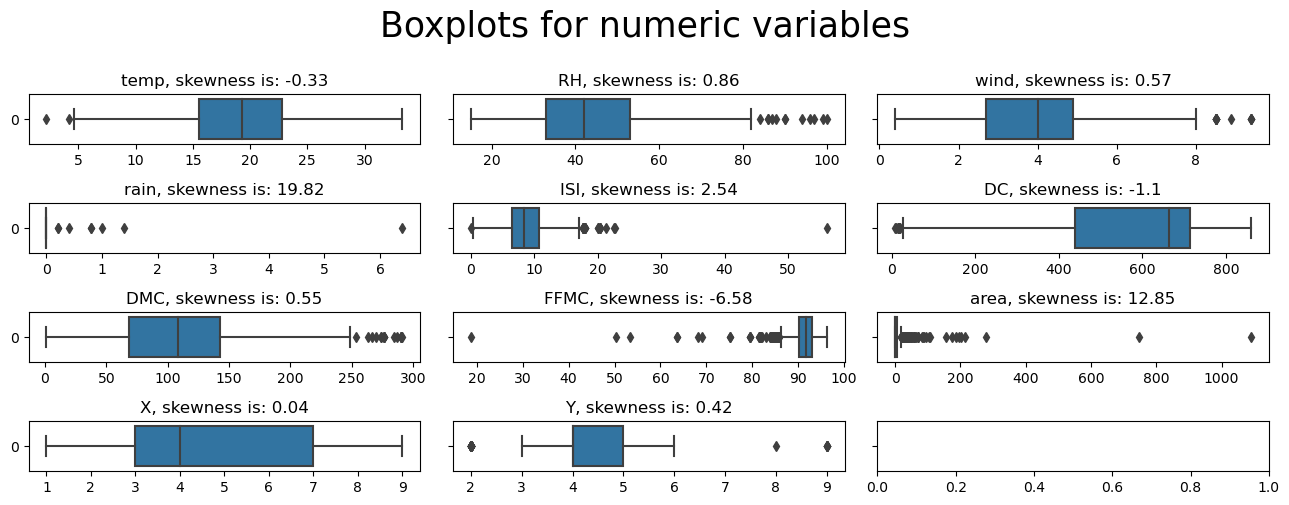

In [15]:
# From https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
numerical_columns = list(df.loc[:,['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','X','Y' ]])
                        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=4, cols=3, suptitle='Boxplots for numeric variables')
plt.tight_layout()

FFMC, ISI, and rain are the most heavily skewed features. The area burned is also heavily skewed, as noted previously.

Now, the categorcal columns (month and day):

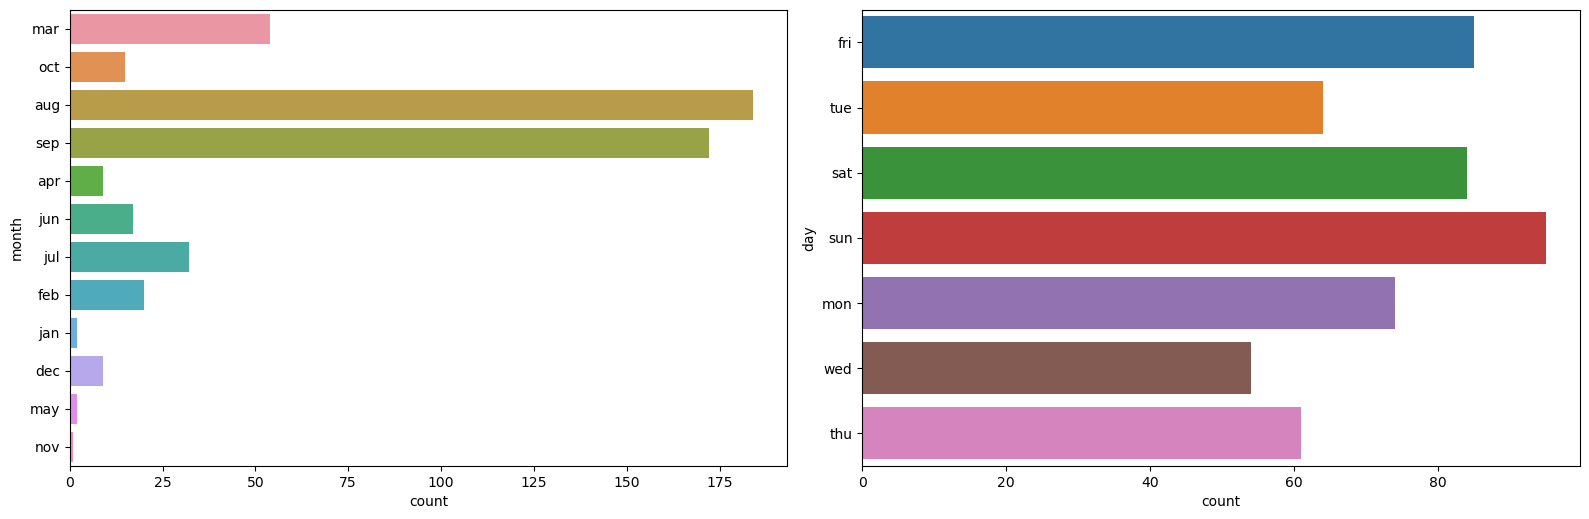

In [16]:
# From https://www.kaggle.com/code/psvishnu/forestfire-impact-prediction-stats-and-ml
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df,y=col)
plt.tight_layout()
plt.show()  

Most fires are, unsurprisingly, in August and September (though not July, oddly). There seems to be no bias for any day of the week, which makes sense.

In [17]:
print('Number of rows with no damage:',df[df['area'] == 0.].shape[0])
print('Number of rows with damage:',df[df['area'] != 0.].shape[0])

Number of rows with no damage: 247
Number of rows with damage: 270


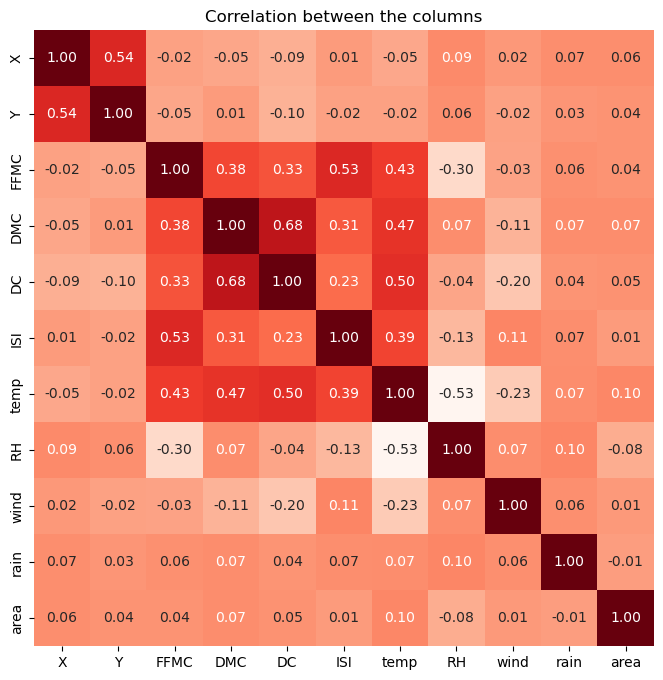

In [18]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Reds', fmt='.2f')
plt.title("Correlation between the columns")
plt.show()

There are certainly correlations, but collinearity is not too severe (|correlation| $ \leq 0.8$).

<AxesSubplot:>

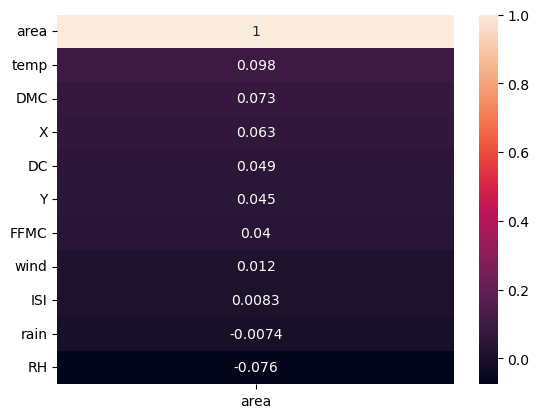

In [19]:
corr = df.corr()[['area']].sort_values(by='area', ascending=False)
sns.heatmap(corr, annot=True)

Unsurprising that temperature is most correlated, but I am surprised rain is relatively unimportant.

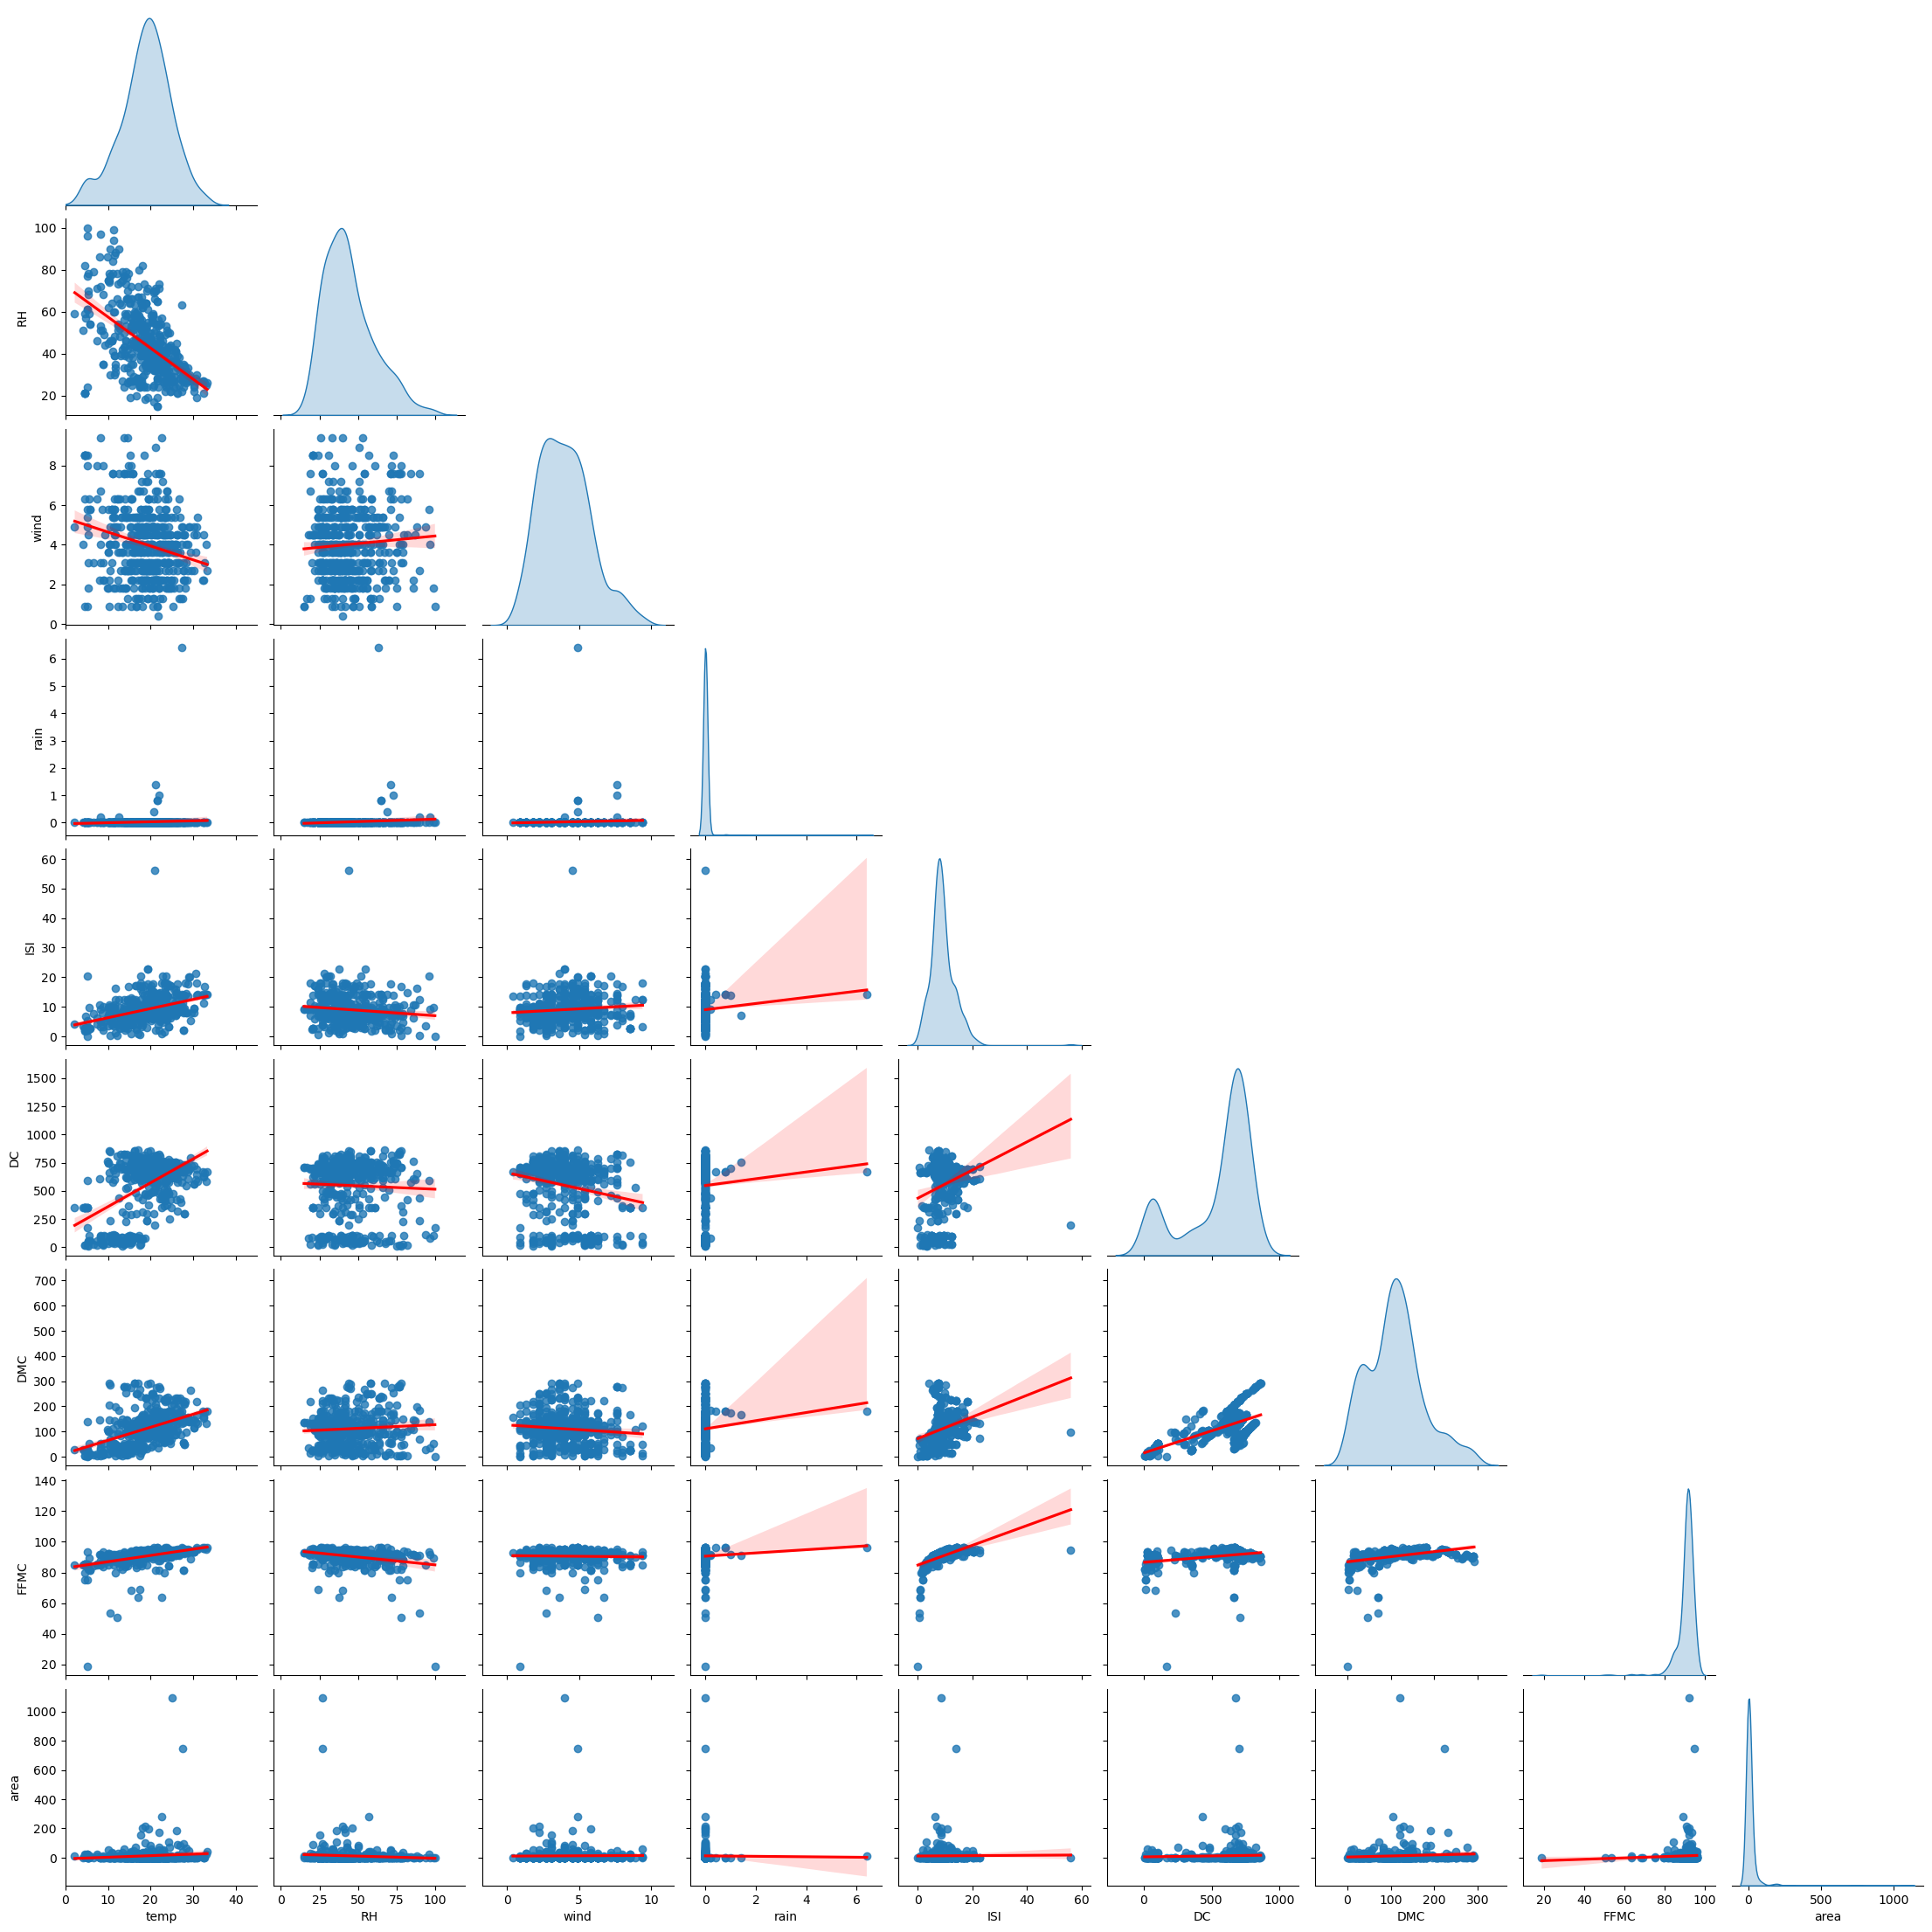

In [20]:
cols_plot = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area']
g = sns.pairplot(df[cols_plot],diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))

In [21]:
# For visualization, may be helpful to make a 
# categorical variable for whether or not there
# was any damage  (this will be dropped before model-building)
def damage_func(area):
    if area == 0.0:
        return "No damage"
    else:
        return "Damage"

df['damage'] = df['area'].apply(damage_func)


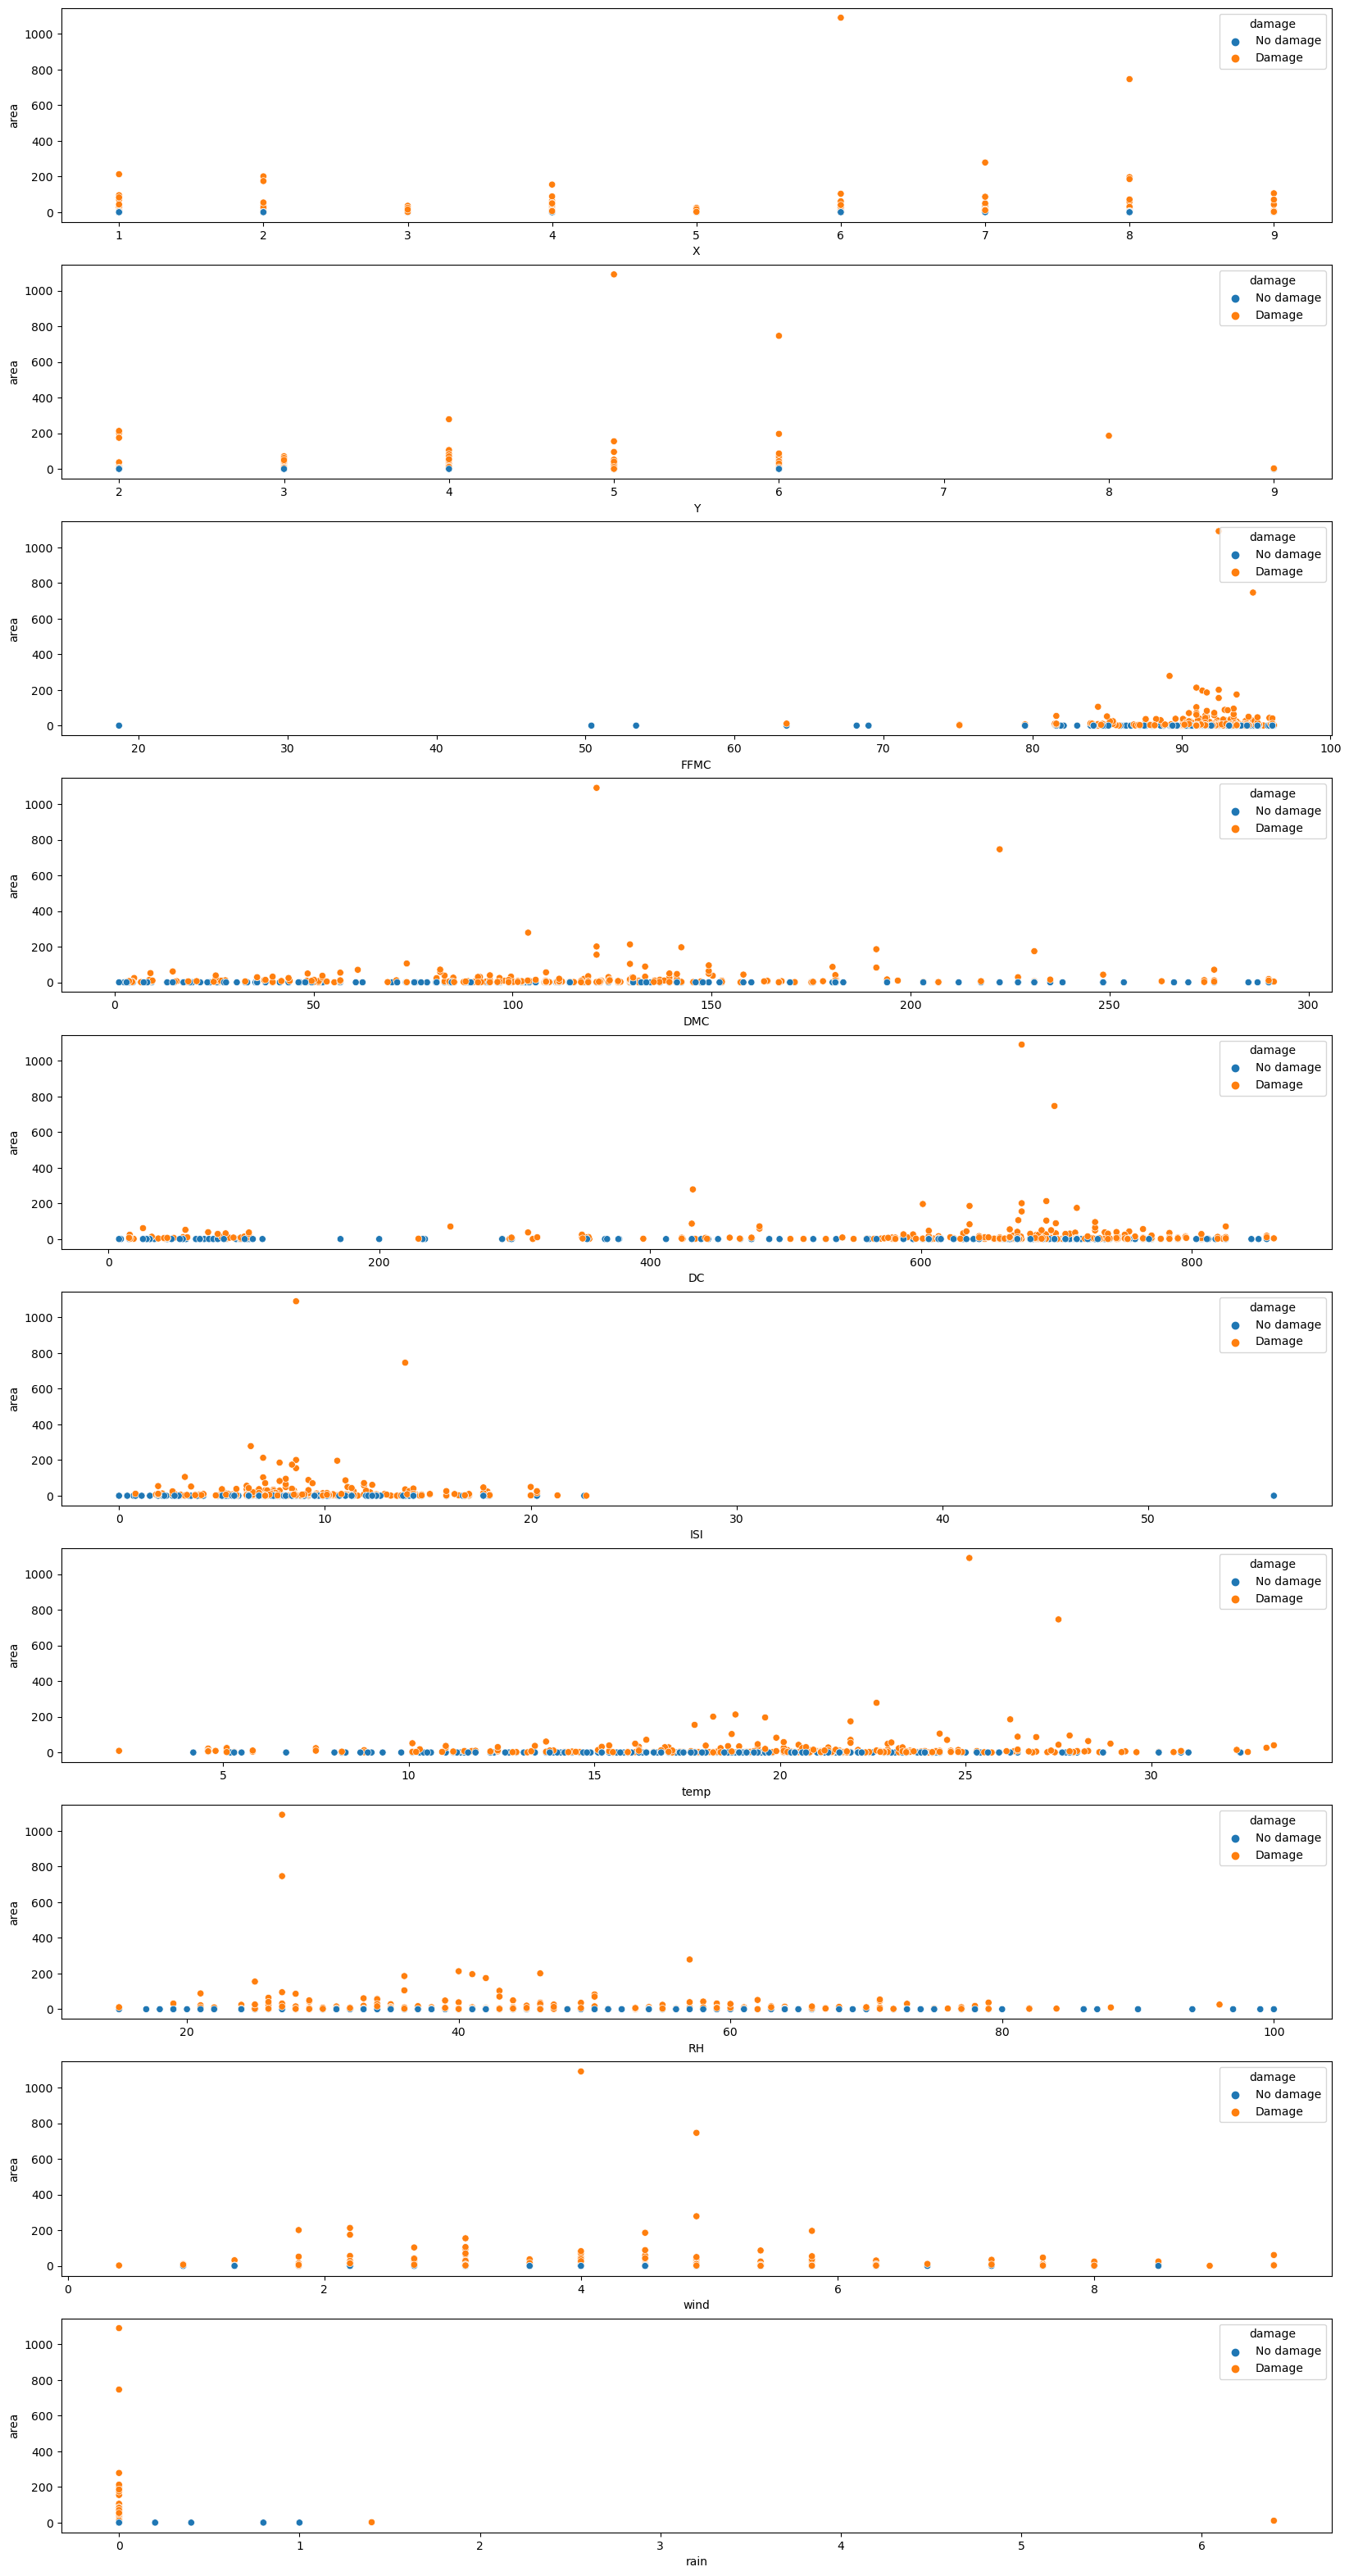

In [22]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    sns.scatterplot(data=df,x=col,y='area',hue='damage')
plt.show()

#The use of the damage hue here is a bit redundant, but helps see low but non-zero areas

Pairplot again, with damage category:

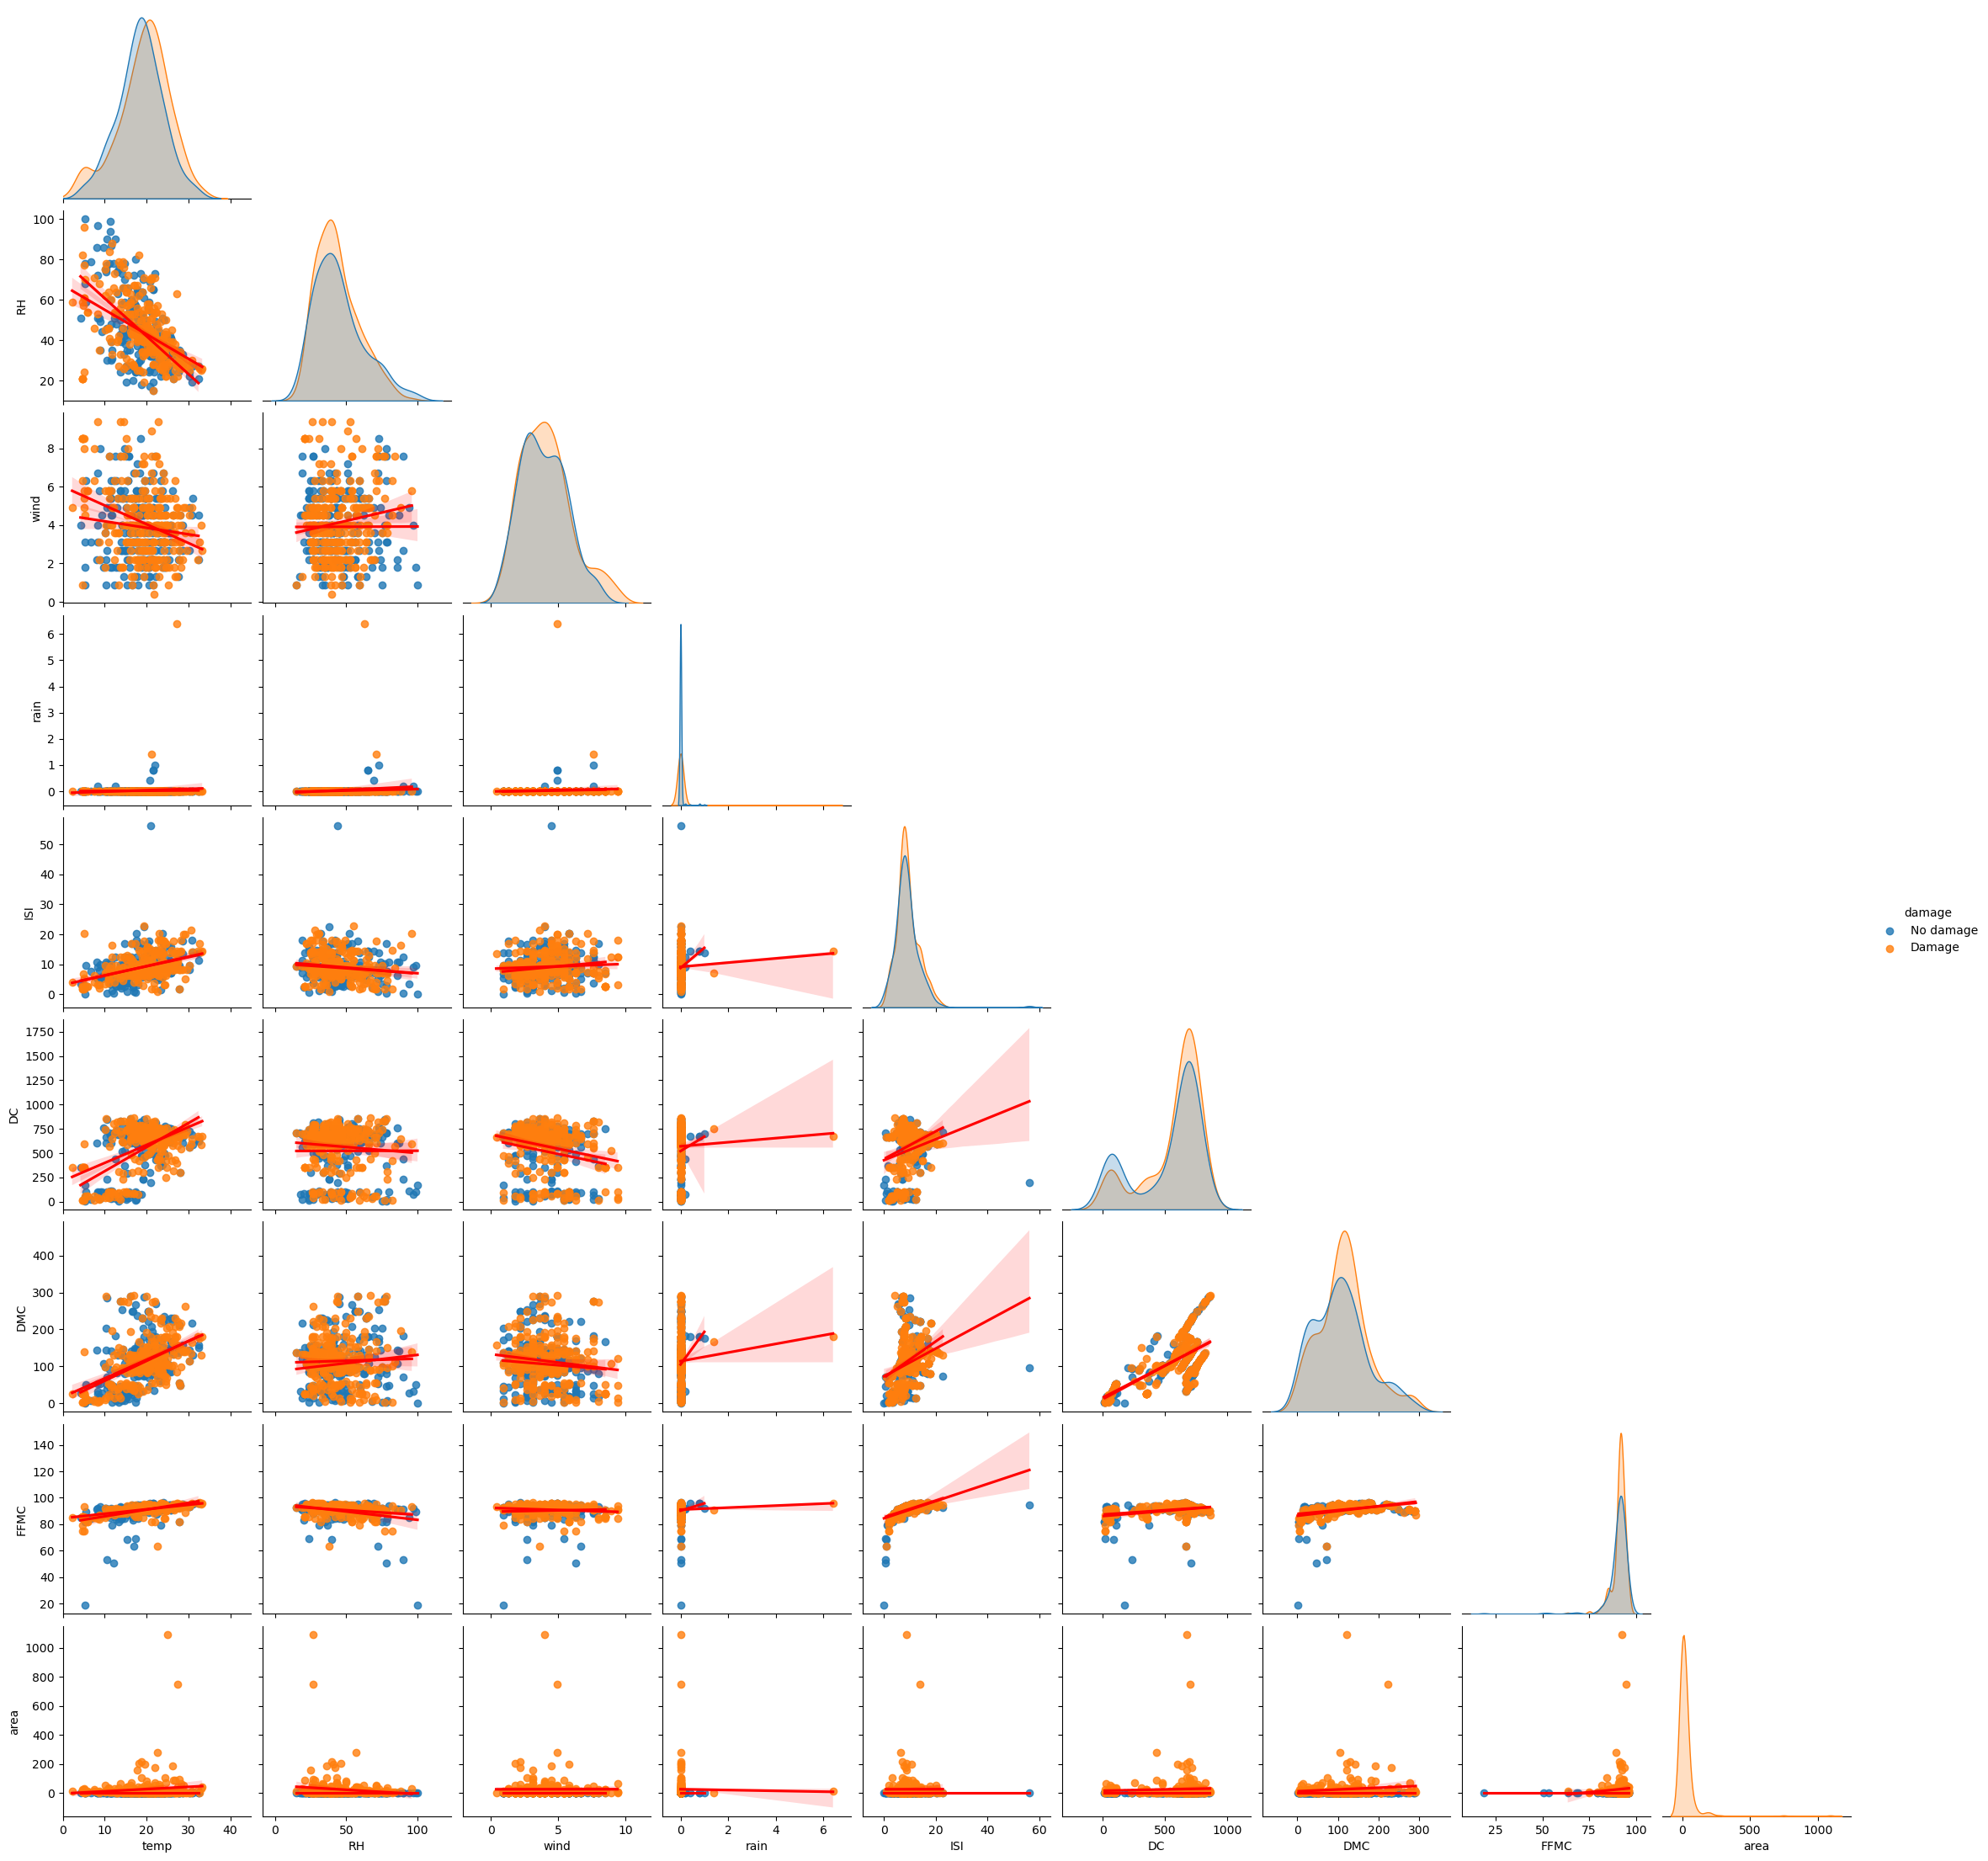

In [23]:
#selected_features = df.drop(columns=['damage','day','month']).columns
cols_plothue = ['temp','RH','wind','rain','ISI','DC','DMC',
                 'FFMC','area','damage']
g = sns.pairplot(df[cols_plothue],hue='damage',diag_kind='kde',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
for i in range(len(cols_plot)):
    g.axes[i,0].set_xlim((0,45))
plt.show()

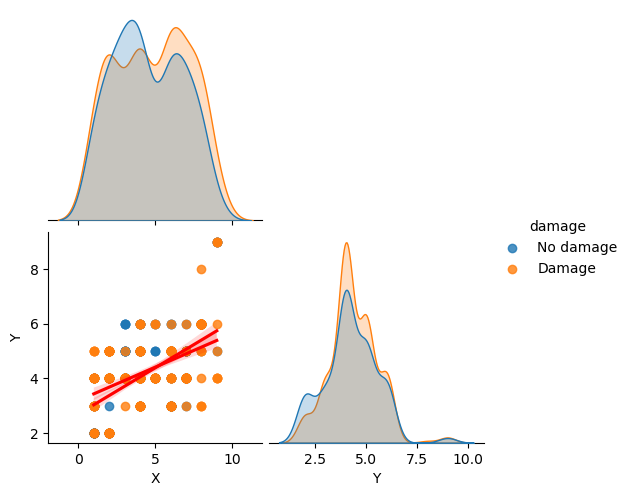

In [24]:
#cols_plothue = ['X','Y']
sns.pairplot(df[['X','Y','damage']],hue='damage',kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})#,vars=selected_features)
#for i in range(len(cols_plot)):
#    g.axes[i,0].set_xlim((0,45))
plt.show()

It is interesting to see more damaged areas in the East than West. I wonder if this is just because of low number of datapoints, or something about the geography of the region.

In [25]:
# Before applying ML, should drop new category
df = df.drop('damage', axis=1)

In [26]:
# Categorical: Month and day
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

# Model Building

After model fitting, I apply the reverse log transform, to compare with test data (RMSE has same units as target, and it's more intuitive to report in units of area rather than log area).

In [27]:
# Log transform
df['area'] = np.log(1 + df['area'])

# Creating bins of in the target, to stratify in train/test split
df['area_bin'] = pd.cut(df['area'], 5)
X = df.drop(columns='area') 
y = df['area']


First, there is a bit of an issue due to the dataset's small size. I noticed setting a random seed for reproducibility had a large affect on the final model and predictions. I illustrate this below:

In [28]:
rmse_res = []
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=i,
                                                   stratify=df[['area_bin']])
    X_train = X_train.drop(columns='area_bin',axis=1)
    X_test = X_test.drop(columns='area_bin',axis=1)

    lr = LinearRegression()

    lr.fit(X_train, Y_train)
    y_pred = np.exp(lr.predict(X_test)) - 1
    rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
    #print('Random state = ',i)
    #print(f'RMSE: {rmse}')
    rmse_res.append(rmse)

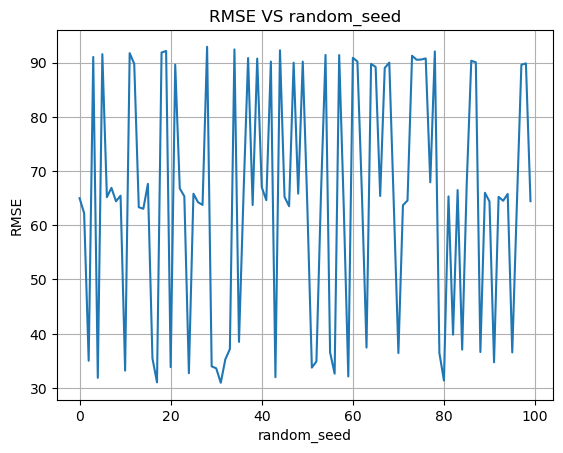

Mean:  64.76060698955546
Stdev:  21.732525937265823


In [29]:
plt.plot(rmse_res)
plt.title("RMSE VS random_seed")
plt.xlabel('random_seed')
plt.ylabel('RMSE')
plt.grid()
plt.show()
print('Mean: ',np.mean(rmse_res))
print('Stdev: ',np.std(rmse_res))

I find a similar result with RandomForest. I believe the issue here is the one described here: https://towardsdatascience.com/is-a-small-dataset-risky-b664b8569a21 For small datasets, different seeds in train_test_split can produce very different models, and result in different values for the model error.

I may try to redo this later with synthetic data, to avoid the problem. For now, I will stick with a random_seed that gives roughly the average RMSE seen above.

In [30]:
rs = 99
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=rs,
                                                   stratify=df[['area_bin']])
X_train = X_train.drop(columns='area_bin',axis=1)
X_test = X_test.drop(columns='area_bin',axis=1)

In [31]:
# Useful function for hyperparameter tuning
def Grid_and_eval(classifier,params,cv=10):
    parameters = params
    model_cv = GridSearchCV(classifier,parameters,cv=cv,
                            scoring='neg_root_mean_squared_error',
                            verbose=0,
                            error_score=np.nan)
    model_cv.fit(X_train,Y_train) 
    print("Tuned hyperparameters: ",model_cv.best_params_)
    print("Mean CV score of best_estimator, on Training:",model_cv.best_score_)
    best_model = model_cv.best_estimator_
    print("Best estimator:",best_model)
    
    y_pred_test = np.exp(best_model.predict(X_test)) - 1
    y_pred_Train = np.exp(best_model.predict(X_train)) - 1
    rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
    rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
    
    print(f'Test RMSE: {rmse_Test}')
    print(f'Train RMSE: {rmse_Train}')
    mae = mean_absolute_error(np.exp(Y_test)-1, y_pred_test)
    print(f'Test MAE: {mae}')

# Baseline Models

**Linear Regression**

In [32]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

y_pred = np.exp(lr.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred)
print(f'Test set RMSE: {rmse}')
print(f'Test set MAE: {mae}')

y_pred = np.exp(lr.predict(X_train)) - 1
rmse = mean_squared_error(np.exp(Y_train)-1, y_pred,squared=False)
print(f'Train RMSE: {rmse}')

Test set RMSE: 64.43626049084423
Test set MAE: 13.848830422339939
Train RMSE: 64.16473380074774


And with StandardScaler, in order to interpret the coefficients for feature importance:

In [33]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, Y_train)  
y_pred = np.exp(pipe.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
print(f'Test set RMSE: {rmse}')

Test set RMSE: 64.43626049084423


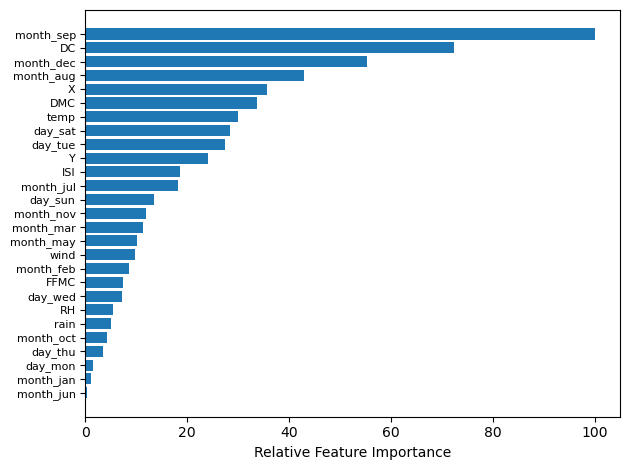

In [34]:
# Feature Importance, on Test set --------------------
feature_importance = abs(pipe[-1].coef_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
#print(sorted_idx)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

**Random Forest**

RMSE: 64.24701158585484
MAE: 13.946332849970268


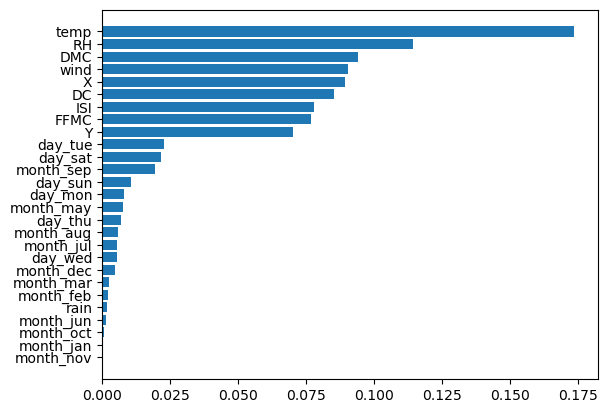

In [35]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

y_pred = np.exp(rf.predict(X_test)) - 1
rmse = mean_squared_error(np.exp(Y_test)-1, y_pred,squared=False)
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Feature importance ----------------
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

There is a fair amount of disagreement about the most relevant features, but important ones are Temperature, DMC, X, Y, ISI, and DC.

# Grid search 

In [36]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
result = Grid_and_eval(RandomForestRegressor(random_state=rs),{
    'n_estimators': [100,300,500],
    'max_depth': [None,1,2],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3,4]
},cv=10)

# Going to n_estimators=700 gave nearly identical results

Tuned hyperparameters:  {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}
Mean CV score of best_estimator, on Training: -1.381714176408448
Best estimator: RandomForestRegressor(max_depth=1, min_samples_leaf=3, n_estimators=500,
                      random_state=99)
Test RMSE: 64.4780096676812
Train RMSE: 64.46740603536259
Test MAE: 13.825770182400415


Test RMSE: 64.4780096676812
Train RMSE: 64.46740603536259
Test MAE: 13.825770182400415


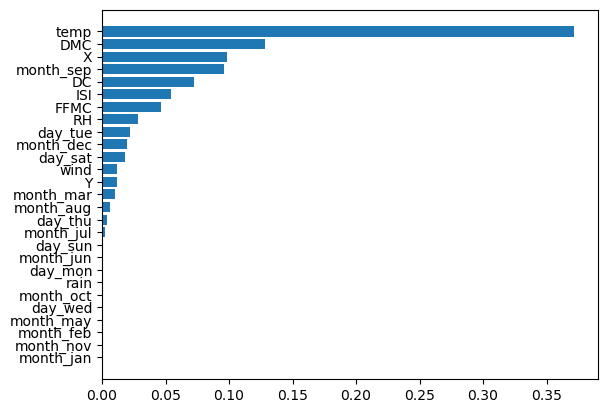

In [37]:
# Just redoing the above
rf = RandomForestRegressor(random_state=rs,
                           max_depth=1,min_samples_leaf=3,min_samples_split=2,
                           n_estimators=500)
rf.fit(X_train, Y_train)

y_pred_test = np.exp(rf.predict(X_test)) - 1
y_pred_Train = np.exp(rf.predict(X_train)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')
mae = mean_absolute_error(np.exp(Y_test)-1, y_pred_test)
print(f'Test MAE: {mae}')

# Feature importance ----------------
importance = rf.feature_importances_
indices = np.argsort(importance)
fig, ax = plt.subplots()
ax.barh(range(len(importance)), importance[indices])
ax.set_yticks(range(len(importance)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

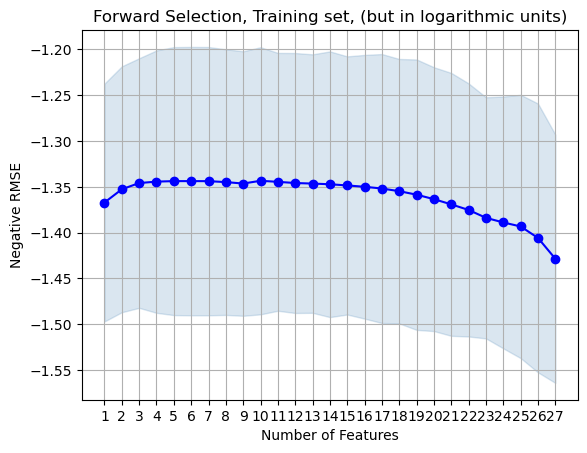

Best feature combo: ('X', 'Y', 'temp', 'RH', 'day_tue', 'month_dec', 'month_jan', 'month_jul', 'month_nov', 'month_sep')
Test RMSE: 64.48315651394954
Train RMSE: 64.35857362053594


In [38]:
# Forward selection ------------------------
model = LinearRegression()
sfs1 = sfs(model,k_features="best",
           forward=True,
           scoring='neg_root_mean_squared_error',
           cv=5)
sfs1.fit(X_train,Y_train)

#Plot performance ------------------------
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection, Training set, (but in logarithmic units)')
plt.ylabel('Negative RMSE')
plt.grid()
plt.show()


print("Best feature combo:",sfs1.k_feature_names_)

# Refit with only best features ------------------------
X_train_sele = sfs1.transform(X_train)
X_test_sele = sfs1.transform(X_test)
model.fit(X_train_sele,Y_train)
y_pred_test = np.exp(model.predict(X_test_sele)) - 1
y_pred_Train = np.exp(model.predict(X_train_sele)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')



#index = list(sfs1.k_feature_idx_)
#X_train1 = X_train.iloc[:,index]
#X_test1 = X_test.iloc[:,index]
#model1 = LinearRegression().fit(X_train1,Y_train_log)
#y_pred_train = np.exp(model1.predict(X_train1)) - 1
#y_pred_test = np.exp(model1.predict(X_test1)) - 1
#print(f"(Redo)Train Score: {mean_squared_error(Y_train_orig, y_pred_train, squared=False)}")
#print(f"(Redo)Test Score: {mean_squared_error(Y_test, y_pred_test, squared=False)}")


In [39]:
#metric_dict = sfs1.get_metric_dict()
#dict_df = pd.DataFrame.from_dict(metric_dict).T
#dict_df

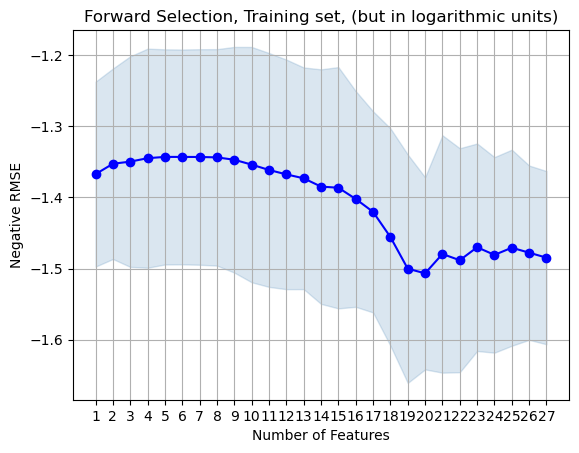

Best feature combo: ('day_tue', 'month_dec', 'month_mar', 'month_oct', 'month_sep')
Test RMSE: 64.54135188695393
Train RMSE: 64.370463832622


In [40]:
# Forward selection, Random Forest ------------------------
model = RandomForestRegressor(random_state=rs)
sfs1 = sfs(model,k_features="best",
           forward=True,
           scoring='neg_root_mean_squared_error',
           cv=5)
sfs1.fit(X_train,Y_train)

#Plot performance ------------------------
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection, Training set, (but in logarithmic units)')
plt.ylabel('Negative RMSE')
plt.grid()
plt.show()


print("Best feature combo:",sfs1.k_feature_names_)

# Refit with only best features ------------------------
X_train_sele = sfs1.transform(X_train)
X_test_sele = sfs1.transform(X_test)
model.fit(X_train_sele,Y_train)
y_pred_test = np.exp(model.predict(X_test_sele)) - 1
y_pred_Train = np.exp(model.predict(X_train_sele)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')

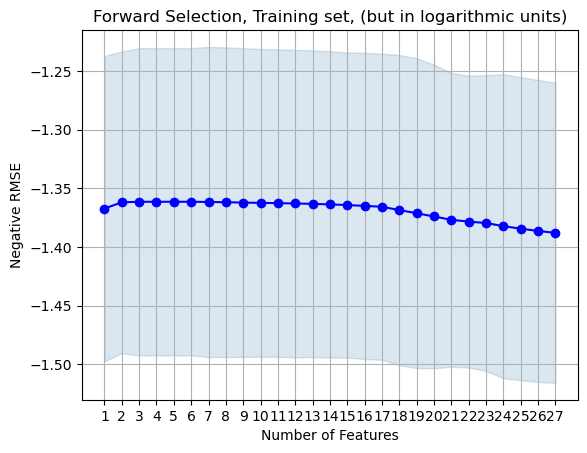

Best feature combo: ('month_dec', 'month_mar', 'month_sep')
Test RMSE: 64.51825985023207
Train RMSE: 64.47540405767063


In [41]:
# Forward selection, Random Forest w best params ------------------------
model = RandomForestRegressor(random_state=rs,
                             max_depth=1,min_samples_leaf=3,min_samples_split=2,
                           n_estimators=500)
sfs1 = sfs(model,k_features="best",
           forward=True,
           scoring='neg_root_mean_squared_error',
           cv=5)
sfs1.fit(X_train,Y_train)

#Plot performance ------------------------
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection, Training set, (but in logarithmic units)')
plt.ylabel('Negative RMSE')
plt.grid()
plt.show()


print("Best feature combo:",sfs1.k_feature_names_)

# Refit with only best features ------------------------
X_train_sele = sfs1.transform(X_train)
X_test_sele = sfs1.transform(X_test)
model.fit(X_train_sele,Y_train)
y_pred_test = np.exp(model.predict(X_test_sele)) - 1
y_pred_Train = np.exp(model.predict(X_train_sele)) - 1
rmse_Test = mean_squared_error(np.exp(Y_test)-1, y_pred_test,squared=False)
rmse_Train = mean_squared_error(np.exp(Y_train)-1, y_pred_Train,squared=False)
print(f'Test RMSE: {rmse_Test}')
print(f'Train RMSE: {rmse_Train}')

# Conclusions

In Cortez & Morais, the best result was RMSE=63.7, MAE=12.7. I find similar results on my test set; the RandomForest Baseline result was RMSE=64.3, which did not improve with a GridSearch. And the MAE was 13.83, in both RandomForest Baseline and GridSearch.

Between LR and RF, there is a fair amount of disagreement about the most relevant features, but the most important ones are Temperature, DMC, X, Y, ISI, and DC. This disagrees with Cortez & Morais that the coordinates are unimportant. 

I plan to revisit this sometime soon to see if generating some synthetic data will help.